# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Task 4: VAE (completed by Sunday Week 2)

This task is a individual task and should **not** to be uploaded to the Group Locker. No direct support should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics, backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# 1. Load Data
df = pd.read_csv('data.csv')

# 2. Split Data (Features vs Labels)
labels = df['Anom']
features = df.drop('Anom', axis=1)

# 3. Scale the Data (0 to 1)
# Autoencoders work best when inputs are between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# 4. Create Train/Test Split
# We split X_scaled and labels so we have matching y_test for evaluation later
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42
)

print("Data Loaded & Scaled.")
print(f"Training Shape: {X_train_scaled.shape}")
print(f"Test Shape: {X_test_scaled.shape}")

Data Loaded & Scaled.
Training Shape: (39277, 9)
Test Shape: (9820, 9)


Starting VAE Training...
Epoch 10: Total=0.2356, Recon=0.2354, KL=0.0002
Epoch 20: Total=0.2355, Recon=0.2355, KL=0.0000
Epoch 30: Total=0.2353, Recon=0.2353, KL=0.0000
Epoch 40: Total=0.2354, Recon=0.2354, KL=0.0000
Epoch 50: Total=0.2353, Recon=0.2353, KL=0.0000
Epoch 60: Total=0.2352, Recon=0.2352, KL=0.0000
Epoch 70: Total=0.2353, Recon=0.2353, KL=0.0000
Epoch 80: Total=0.2351, Recon=0.2351, KL=0.0000
Epoch 90: Total=0.2351, Recon=0.2351, KL=0.0000
Epoch 100: Total=0.2352, Recon=0.2352, KL=0.0000
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


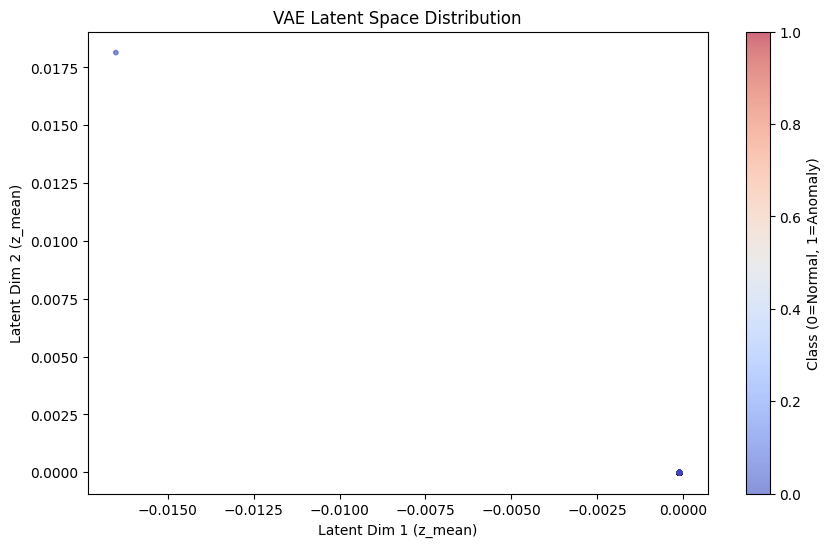

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

VAE Threshold (92nd percentile): 0.0090

VAE Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9100
           1       0.88      0.96      0.92       720

    accuracy                           0.99      9820
   macro avg       0.94      0.97      0.96      9820
weighted avg       0.99      0.99      0.99      9820

VAE Confusion Matrix:


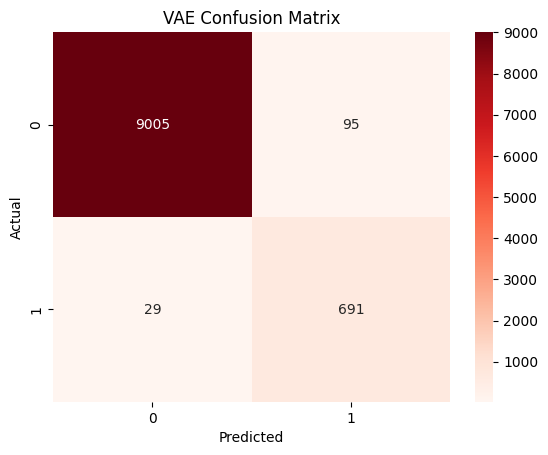

In [6]:
# ==========================================
# Task 4: Variational Autoencoder (VAE)
# ==========================================

# ---------------------------------------------------------
# 1. Define the Sampling Layer (Reparameterization Trick)
# [SOURCE: Adapted from REF_CNN_AE.ipynb]
# This logic is standard for VAEs to allow backpropagation through random sampling.
# ---------------------------------------------------------
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ---------------------------------------------------------
# 2. Define the VAE Model Class (Custom Train Step)
# [SOURCE: Adapted from REF_CNN_AE.ipynb]
# The Class structure and 'train_step' are lifted from the reference file
# to handle the dual loss function (Reconstruction + KL Divergence).
# ---------------------------------------------------------
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Trackers for metrics (standard Keras pattern found in REF)
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # A. Reconstruction Loss
            # [NOTE: Changed from Binary Crossentropy (in REF) to MSE (for your Data)]
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mse(data, reconstruction), axis=None
                )
            )

            # B. KL Divergence
            # [SOURCE: Exact formula from REF_CNN_AE.ipynb]
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation (Standard Logic)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# ---------------------------------------------------------
# 3. Build Encoder & Decoder
# [SOURCE: YOUR TASK 2 ARCHITECTURE]
# I replaced the CNN layers from the REF file with your Dense layers.
# ---------------------------------------------------------
input_dim = X_train_scaled.shape[1]
latent_dim = 2

# -- Encoder --
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(7, activation="relu")(encoder_inputs) # [Your Topology]
x = layers.Dense(4, activation="relu")(x)              # [Your Topology]

# [SOURCE: REF File Logic] - Splitting the bottleneck into Mean and LogVar
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# -- Decoder --
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(4, activation="relu")(latent_inputs)  # [Your Topology]
x = layers.Dense(7, activation="relu")(x)              # [Your Topology]
decoder_outputs = layers.Dense(input_dim, activation="linear")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# 4. Instantiate and Train
# ---------------------------------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

print("Starting VAE Training...")
history_vae = vae.fit(
    X_train_scaled,
    epochs=100,
    batch_size=64,
    verbose=0,
    callbacks=[
        # [SOURCE: Hint in Instructions] - Printing KL and Recon loss separately
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(
                f"Epoch {epoch+1}: Total={logs['loss']:.4f}, "
                f"Recon={logs['reconstruction_loss']:.4f}, KL={logs['kl_loss']:.4f}"
            ) if (epoch+1)%10 == 0 else None
        )
    ]
)

# 5. Analysis (Same as Task 3)
# ---------------------------------------------------------
z_mean_test, _, _ = vae.encoder.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(label="Class (0=Normal, 1=Anomaly)")
plt.xlabel("Latent Dim 1 (z_mean)")
plt.ylabel("Latent Dim 2 (z_mean)")
plt.title("VAE Latent Space Distribution")
plt.show()

# Calculate Reconstruction Error
reconstructed_vae = vae.predict(X_test_scaled)
mse_vae = np.mean(np.power(X_test_scaled - reconstructed_vae, 2), axis=1)

# Threshold & Report
threshold_vae = np.percentile(mse_vae, 92)
print(f"\nVAE Threshold (92nd percentile): {threshold_vae:.4f}")

y_pred_vae = (mse_vae > threshold_vae).astype(int)

print("\nVAE Classification Report:")
print(classification_report(y_test, y_pred_vae))

print("VAE Confusion Matrix:")
cm_vae = confusion_matrix(y_test, y_pred_vae)
sns.heatmap(cm_vae, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('VAE Confusion Matrix')
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.